In [75]:
import sys

sys.path.append("./../..")

from numba import jit
from numba.types import bool_, int_
import numpy as np
import matplotlib.pyplot as plt
from InternalLibrary.StatisticalFunctions import stat_corr_single
from scipy.optimize import curve_fit
from scipy.stats import moment

from tqdm import tqdm

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
import torch

# The Run and Tumble Model

A particle undergoing RnT motion moves in a sequence of runs at constant self-propulsion speed $\omega$ interrupted by sudden changes (tumbles) in its orientation that happen at Poissonian rate $\alpha$

The simulator runs the RnT model for a given number of particles and time steps. The particles are initialized all at $x_0 = 0$ and right facing velocity.
The particles move in 1D space with an harmonic potential $V(x) = \frac{1}{2} k x^2$ acting on them. There are no boundary conditions.

At a rate $\alpha$ the particles change their velocity to the opposite direction.

The simulation is done in the following way:
1. Initialize the particles at $x_0 = 0$ and right facing velocity.
2. Check if a tumble event happens at the current time step.
2. Update the position of the particles according to the current velocity, potential and add a stochastic term to the velocity.

The equation of motion is:
$$
\dot{x} = -\partial_x V(x) \pm \omega + \nu(t)
$$

In [76]:
@jit
def RunTumble(param, n_sim,dt=0.01, TotalT=1, alpha=0.5, keep_f = False, D = 0):
    k = param[0]
    omega = param[1]
    D = omega*omega / alpha
    
    total_time_steps = np.int64(TotalT / dt)
    
    x = np.zeros((1, n_sim))
    x_trace = np.zeros((n_sim, total_time_steps))
    
    direction = np.ones((1, n_sim))
    f_trace = np.zeros((n_sim, total_time_steps))
    
    for n in range(1, total_time_steps):
        change = np.random.uniform(0, 1, size=(1, n_sim)) < alpha * dt / 2 # Change direction with probability alpha*dt/2
        change = -(change *2 -1) # From boolean to -1 or 1 (false = 1, true = -1)
        direction = change*direction # Change direction if change is true
        nu = np.random.normal(0, 1, size=(1, n_sim))
        x[:] = x[:] + (-k * x[:] + omega * direction) * dt + np.sqrt(2 * D * dt) * nu
        x_trace[:, n] = x[:,]
        if keep_f:
            f_trace[:, n] = ((-k * x[:] + omega * direction) * dt + np.sqrt(2 * D * dt) * nu)[:,]

    return x_trace, f_trace

Let us define the parameters of our model and simulation. As this is a highly stochastic model, we will run the simulation for a large number of particles.

In [77]:
ModelParameter = np.array([1, 1]) # [k, omega]
NumberOfParticles = 1000 # Number of particles to simulate
TotalTime = 2 # Total time of simulation
dt = 1e-3 # Time step
alpha = 0.5 # Tumbling rate
t = np.arange(0, TotalTime, dt) # Time vector

Let's simulate a single example particle and visualize its trajectory.

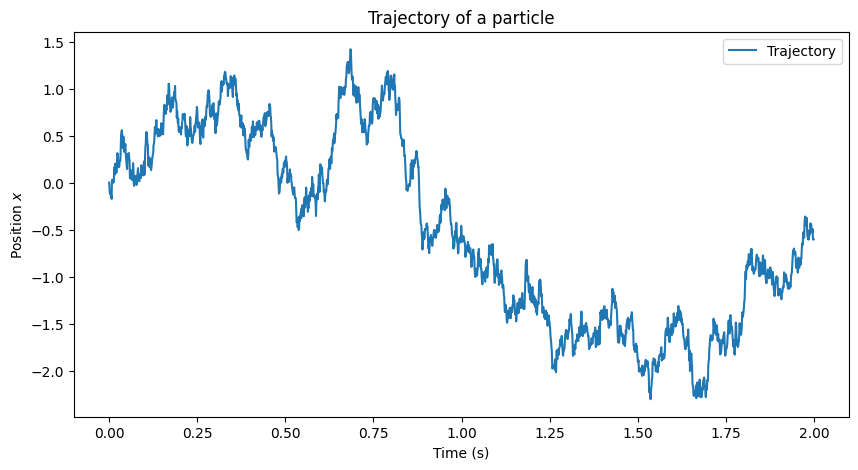

In [78]:
x_trace = RunTumble(ModelParameter, NumberOfParticles, dt, TotalTime, alpha)[0] # Run the model

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(t, x_trace[0,:], label="Trajectory")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position $x$")
ax.legend()
ax.set_title("Trajectory of a particle");


We can also see the distribution of the trajectories of the particles.

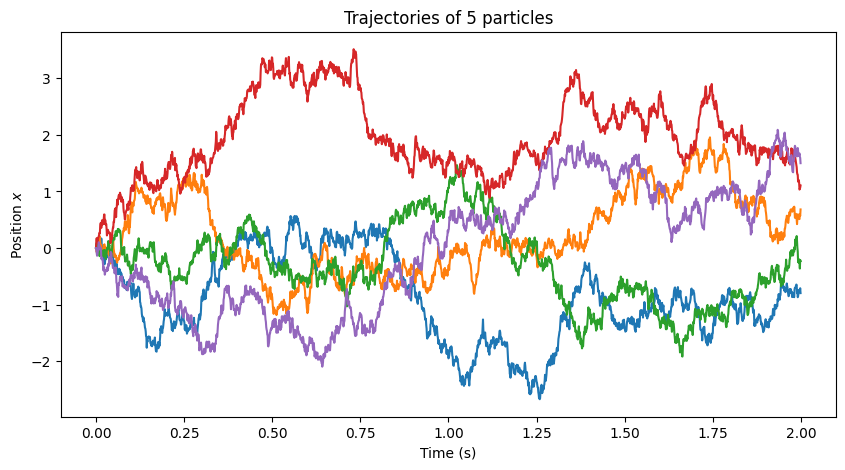

In [79]:
x_trace = RunTumble(ModelParameter, NumberOfParticles, dt, TotalTime, alpha)[0] # Run the model

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in np.arange(0, 5):
    ax.plot(t, x_trace[i,:], label="Trajectory")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position $x$")
ax.set_title("Trajectories of 5 particles");

# Theoretical Observables

From the paper we can derive the following observables for the RnT model, and check them against our simulations. All averages are taken over the ensemble of particles.

First moment of the position of a RnT particle:

$$\langle x(t) \rangle = x_0 e^{-kt} + \frac{\omega}{k - \alpha} \left(e^{-\alpha t}- e^{-kt}\right)$$

Second moment of the position of a RnT particle:

$$
\begin{aligned}
\left\langle x^2(t)\right\rangle &= x_0^2 e^{-2 k t}+\frac{D}{k}\left(1-e^{-2 k t}\right)+2 \frac{x_0 w}{k-\alpha}\left(e^{-(k+\alpha) t}-e^{-2 k t}\right) \\
& +2 w^2\left(\frac{\exp (-2 k t)}{2 k(k-\alpha)}+\frac{\exp (-(k+\alpha) t)}{(k+\alpha)(\alpha-k)}+\frac{1}{2 k(k+\alpha)}\right)
\end{aligned}
$$

Then, the mean square displacement at stationarity is
$$
\lim _{t \rightarrow \infty} R^2(t)=x_0^2+\frac{D}{k}+\frac{w^2}{k(k+\alpha)}
$$

In [80]:
## Helper Functions
def EmpiricalFirstMoment(data):
    return np.mean(data,axis = 0)

def EmpiricalSecondMoment(data):
    return np.mean(data**2,axis=0)

def TheoricalFirstMoment(k, omega, alpha, t, x0 = 0):
    return x0 * np.exp(-k*t) + (omega / (k - alpha)) * (np.exp(-alpha*t) - np.exp(-k*t))

def TheoricalSecondMoment(k, omega, alpha, t, x0 = 0):
    D = omega**2 / alpha
    return  x0**2 * np.exp(-2*k*t) + D/k * (1 - np.exp(-2*k*t)) + 2*x0*omega/(k-alpha) * (np.exp(-(k+alpha)*t) - np.exp(2*k*t)) + 2*omega**2 *(np.exp(-2*k*t/(2*k*(k-alpha))) + np.exp(-(k+alpha)*t)/((k+alpha)*(alpha-k)) + 1/(2*k*(k+alpha)))

def MeanSquareDisplacement(k, omega, alpha, x0 = 0):
    D = omega**2 / alpha
    return x0**2 + D/k + omega**2/(k*(k+alpha))

Let's define some parameters, for example $k = 1, \omega = 1, \alpha = 0.5$ and run the simulation for a large number of particles to check the observables.

In [81]:
k = 1
omega = 1
alpha = 0.5

ModelParameter = np.array([k, omega]) # [k, omega]
NumberOfParticles = 10000 # Number of particles to simulate
TotalTime = 5 # Total time of simulation
dt = 1e-4 # Time step
t = np.arange(0, TotalTime, dt) # Time vector

x_trace = RunTumble(ModelParameter, NumberOfParticles, dt, TotalTime, alpha)[0] # Run the model

# Compute the empirical first and second moments
EmpiricalFirstMoment_ = EmpiricalFirstMoment(x_trace)
EmpiricalSecondMoment_ = EmpiricalSecondMoment(x_trace)

# Compute the theoretical first and second moments
TheoreticalFirstMoment_ = TheoricalFirstMoment(k, omega, alpha, t)
TheoreticalSecondMoment_ = TheoricalSecondMoment(k, omega, alpha, t)

MeanSquareDisplacement_ = MeanSquareDisplacement(k, omega, alpha)

Let us visualize the results to check if the observables are correctly calculated and the simulator agrees with the theoretical results.

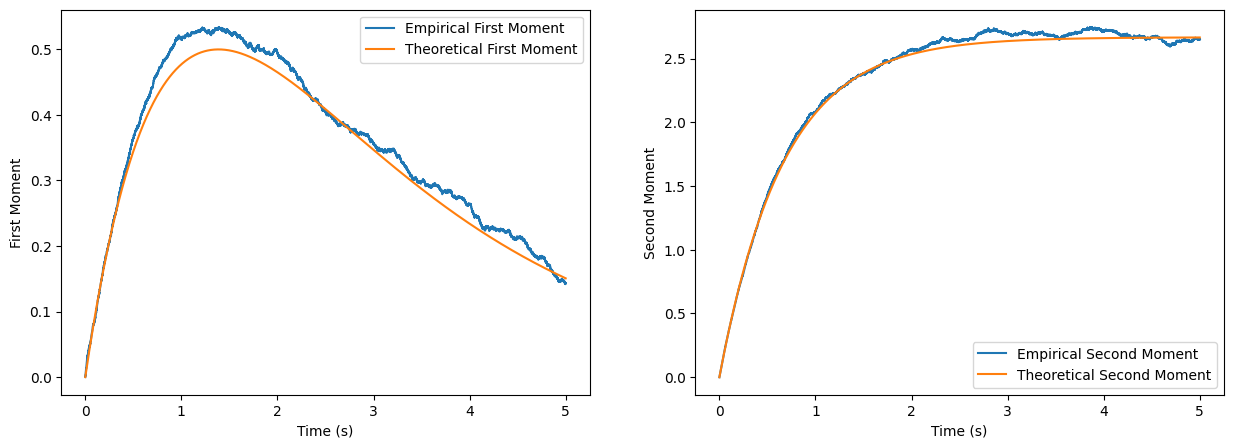

In [82]:
# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(t, EmpiricalFirstMoment_, label="Empirical First Moment")
ax[0].plot(t, TheoreticalFirstMoment_, label="Theoretical First Moment")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("First Moment")
ax[0].legend()

ax[1].plot(t, EmpiricalSecondMoment_, label="Empirical Second Moment")
ax[1].plot(t, TheoreticalSecondMoment_, label="Theoretical Second Moment")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Second Moment")
ax[1].legend();

As we can see, the theoretical results are in agreement with the simulation results.

# Implementing SBI
## Without summary statistics

We first simulate a large number of particles with a different set of parameters each.



In [83]:
# Define the prior of the parameters and the simulation parameters
prior_limits = {"k": [0, 5], "omega": [0, 5]}
NumberOfSimulations = 10000
ModelParameters = np.array([np.random.uniform(prior_limits["k"][0], prior_limits["k"][1], NumberOfSimulations), np.random.uniform(prior_limits["omega"][0], prior_limits["omega"][1], NumberOfSimulations)])
TotalTime = 2 # Total time of simulation 
dt = 1e-3 # Time step
alpha = 0.5 # Tumbling rate
t = np.arange(0, TotalTime, dt) # Time vector

x_trace = RunTumble(ModelParameters, NumberOfSimulations, dt, TotalTime, alpha)[0]
trace = torch.tensor(x_trace, dtype=torch.float32)
theta = torch.tensor(ModelParameters.T, dtype=torch.float32)

We then execute the SBI pipeline to infer the parameters of the model.

In [84]:
# Define the inference object
prior_box = utils.BoxUniform(low=torch.tensor([prior_limits["k"][0], prior_limits["omega"][0]]), high=torch.tensor([prior_limits["k"][1], prior_limits["omega"][1]]))
prior, num_parameters, prior_returns_numpy = process_prior(prior_box)
infer = SNPE(prior=prior)

# Train density estimator and extrace the posterior
inference = infer.append_simulations(theta, trace)
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 38 epochs.

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

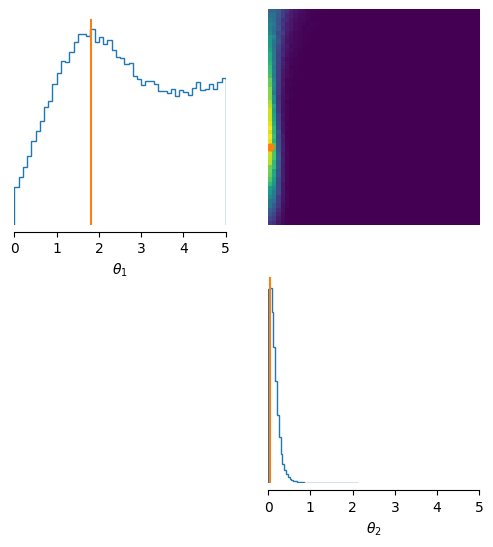

In [85]:
# Generate Test Data
ModelParameters = np.array([np.random.uniform(prior_limits["k"][0], prior_limits["k"][1], 1), np.random.uniform(prior_limits["omega"][0], prior_limits["omega"][1], 1)])
x_test = RunTumble(ModelParameters, 1, dt, TotalTime, alpha)[0]
theta_test = torch.tensor(ModelParameters.T, dtype=torch.float32)
# Use test data to check if the posterior is working
samples = posterior.sample((100000,), x=x_test.reshape(1, len(t)))
_ = analysis.pairplot(samples, points=theta_test, limits=[[0.0, 5.], [0, 5.]], figsize=(6, 6), labels=[r"$\theta_1$", r"$\theta_2$"])

## With Summary Statistics - Autocorrelation

In [86]:
# Define the prior of the parameters and the simulation parameters
prior_limits = {"k": [0, 5], "omega": [0, 5]}
NumberOfSimulations = 10000
ModelParameters = np.array([np.random.uniform(prior_limits["k"][0], prior_limits["k"][1], NumberOfSimulations), np.random.uniform(prior_limits["omega"][0], prior_limits["omega"][1], NumberOfSimulations)])
TotalTime = 2 # Total time of simulation
dt = 1e-3 # Time step
alpha = 0.5 # Tumbling rate
t = np.arange(0, TotalTime, dt) # Time vector
# Generate the data
x_trace = RunTumble(ModelParameters, NumberOfSimulations, dt, TotalTime, alpha)[0]
theta = torch.tensor(ModelParameters.T, dtype=torch.float32)

In [87]:
# Compute the autocorrelation of the data
autocorrelation = np.zeros((NumberOfSimulations, len(t)))
for i in range(NumberOfSimulations):
    autocorrelation[i,:] = stat_corr_single(x_trace[i,:], dt)

trace = torch.tensor(autocorrelation, dtype=torch.float32)

In [89]:
# Define the inference object
prior_box = utils.BoxUniform(low=torch.tensor([prior_limits["k"][0], prior_limits["omega"][0]]), high=torch.tensor([prior_limits["k"][1], prior_limits["omega"][1]]))
prior, num_parameters, prior_returns_numpy = process_prior(prior_box)
infer = SNPE(prior=prior)

# Train density estimator and extrace the posterior
inference = infer.append_simulations(theta, trace)
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 82 epochs.

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

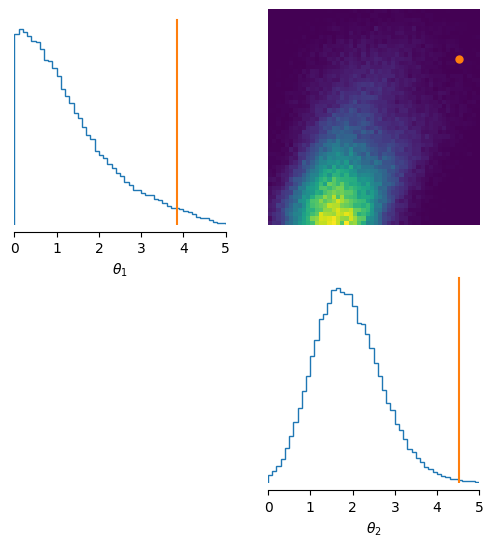

In [92]:
# Generate Test Data
ModelParameters = np.array([np.random.uniform(prior_limits["k"][0], prior_limits["k"][1], 1), np.random.uniform(prior_limits["omega"][0], prior_limits["omega"][1], 1)])
x_test = RunTumble(ModelParameters, 1, dt, TotalTime, alpha)[0]
theta_test = torch.tensor(ModelParameters.T, dtype=torch.float32)
# Use test data to check if the posterior is working
samples = posterior.sample((100000,), x=x_test.reshape(1, len(t)))
_ = analysis.pairplot(samples, points=theta_test, limits=[[0.0, 5.], [0, 5.]], figsize=(6, 6), labels=[r"$\theta_1$", r"$\theta_2$"])

### With Sub-Sampling

In [96]:
# Sample linearly from the autocorrelation
trace = autocorrelation[:,::20]
trace = torch.tensor(trace, dtype=torch.float32)

In [97]:
# Define the inference object
prior_box = utils.BoxUniform(low=torch.tensor([prior_limits["k"][0], prior_limits["omega"][0]]), high=torch.tensor([prior_limits["k"][1], prior_limits["omega"][1]]))
prior, num_parameters, prior_returns_numpy = process_prior(prior_box)
infer = SNPE(prior=prior)

# Train density estimator and extrace the posterior
inference = infer.append_simulations(theta, trace)
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 83 epochs.

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

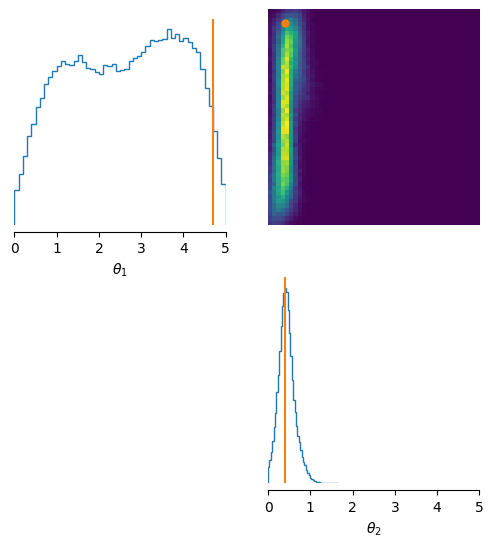

In [98]:
# Generate Test Data
ModelParameters = np.array([np.random.uniform(prior_limits["k"][0], prior_limits["k"][1], 1), np.random.uniform(prior_limits["omega"][0], prior_limits["omega"][1], 1)])
x_test = RunTumble(ModelParameters, 1, dt, TotalTime, alpha)[0]
theta_test = torch.tensor(ModelParameters.T, dtype=torch.float32)
x_test = stat_corr_single(x_test[0,:], dt)
x_test = x_test[::20]
# Use test data to check if the posterior is working
samples = posterior.sample((100000,), x=x_test.reshape(1, trace.shape[1]))
_ = analysis.pairplot(samples, points=theta_test, limits=[[0.0, 5.], [0, 5.]], figsize=(6, 6), labels=[r"$\theta_1$", r"$\theta_2$"])

## With Summary Statistics - Cumulative Mean

In [99]:
# Define the prior of the parameters and the simulation parameters
prior_limits = {"k": [0, 5], "omega": [0, 5]}
NumberOfSimulations = 10000
ModelParameters = np.array([np.random.uniform(prior_limits["k"][0], prior_limits["k"][1], NumberOfSimulations), np.random.uniform(prior_limits["omega"][0], prior_limits["omega"][1], NumberOfSimulations)])
TotalTime = 2 # Total time of simulation
dt = 1e-3 # Time step
alpha = 0.5 # Tumbling rate
t = np.arange(0, TotalTime, dt) # Time vector

x_trace = RunTumble(ModelParameters, NumberOfSimulations, dt, TotalTime, alpha)[0]
theta = torch.tensor(ModelParameters.T, dtype=torch.float32)

In [100]:
# Compute the cumulative mean of the data
cummean = np.cumsum(x_trace, axis=1) / np.arange(1, len(t)+1)
trace = torch.tensor(cummean, dtype=torch.float32)

In [101]:
# Define the inference object
prior_box = utils.BoxUniform(low=torch.tensor([prior_limits["k"][0], prior_limits["omega"][0]]), high=torch.tensor([prior_limits["k"][1], prior_limits["omega"][1]]))
prior, num_parameters, prior_returns_numpy = process_prior(prior_box)
infer = SNPE(prior=prior)

# Train density estimator and extrace the posterior
inference = infer.append_simulations(theta, trace)
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 72 epochs.

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

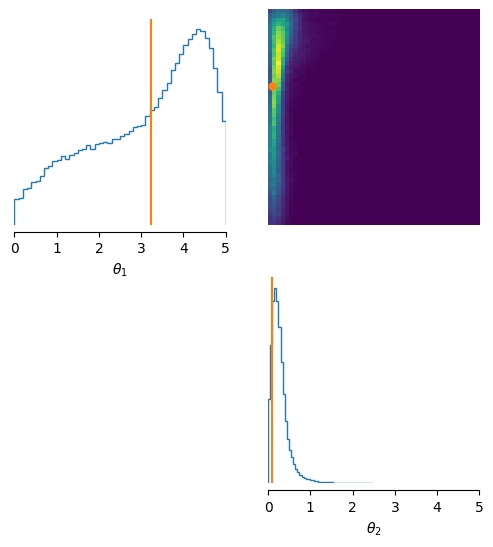

In [102]:
# Generate Test Data
ModelParameters = np.array([np.random.uniform(prior_limits["k"][0], prior_limits["k"][1], 1), np.random.uniform(prior_limits["omega"][0], prior_limits["omega"][1], 1)])
x_test = RunTumble(ModelParameters, 1, dt, TotalTime, alpha)[0]
x_test = np.cumsum(x_test, axis=1) / np.arange(1, len(t)+1)
x_test = torch.tensor(x_test, dtype=torch.float32)
theta_test = torch.tensor(ModelParameters.T, dtype=torch.float32)
# Use test data to check if the posterior is working
samples = posterior.sample((100000,), x=x_test.reshape(1, len(t)))
_ = analysis.pairplot(samples, points=theta_test, limits=[[0.0, 5.], [0, 5.]], figsize=(6, 6), labels=[r"$\theta_1$", r"$\theta_2$"])

# Study of Entropy

The theoretical entropy production rate seems to be given by:
$$
\dot{S} = \frac{\alpha\omega^2}{D(k + \alpha)}
$$

In [103]:
@jit
def RunTumble(param, n_sim,dt=0.01, TotalT=1, alpha=0.5, keep_f = False, D = 0):
    k = param[0]
    omega = param[1]
    if D == 0:
        D = omega**2 / alpha
    
    total_time_steps = np.int64(TotalT / dt)
    
    x = np.zeros((1, n_sim))
    x_trace = np.zeros((n_sim, total_time_steps))
    
    direction = np.ones((1, n_sim))
    f_trace = np.zeros((n_sim, total_time_steps))
    
    for n in range(1, total_time_steps):
        change = np.random.uniform(0, 1, size=(1, n_sim)) < alpha * dt / 2 # Change direction with probability alpha*dt/2
        change = -(change *2 -1) # From boolean to -1 or 1 (false = 1, true = -1)
        direction = change*direction # Change direction if change is true
        nu = np.random.normal(0, 1, size=(1, n_sim))
        x[:] = x[:] + (-k * x[:] + omega * direction) * dt + np.sqrt(2 * D * dt) * nu
        x_trace[:, n] = x[:,]
        if keep_f:
            f_trace[:, n] = ((-k * x[:]) * dt)

    return x_trace, f_trace

In [104]:
def InternalEntropyProduction(alpha, omega, k, D = 0):
    if D == 0:
        D = omega**2 / alpha
    return alpha*omega**2 /(D*(k + alpha))

In [105]:
# Simulate Example trace
ModelParameter = np.array([1, 1]) # [k, omega]
k = ModelParameter[0]
omega = ModelParameter[1]
NumberOfParticles = 10000 # Number of particles to simulate
TotalTime = 10 # Total time of simulation
dt = 1e-3 # Time step
alpha = 0.5 # Tumbling rate
t = np.arange(0, TotalTime, dt) # Time vector

In [106]:
def MeanCumulativeEntropyProduction(positions, forces, t):
    dt = t[1] - t[0]
    S = (positions[:,1:] - positions[:,:-1]) * (forces[:,1:] + forces[:,:-1])/(2*dt)
    S = np.cumsum(S, axis=1) / (t[1:])
    #S = np.cumsum(S, axis=1) / dt
    S = np.mean(S, axis=0)
    return S

The empirical entropy production is: -0.53
The theoretical entropy production is: 0.03


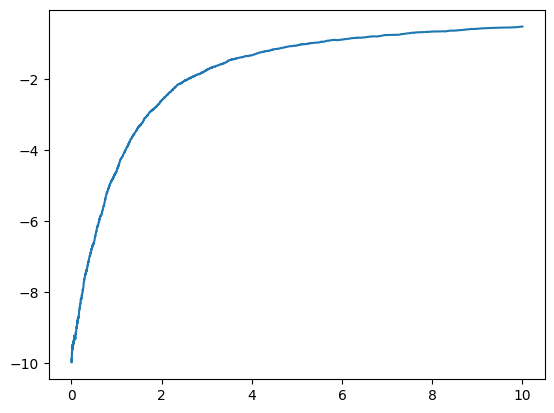

In [107]:
s = np.zeros(NumberOfParticles)
x_trace, f_trace = RunTumble(ModelParameter, NumberOfParticles, dt, TotalTime, alpha, keep_f=True, D = 10) # Run the model
print(f"The empirical entropy production is: {MeanCumulativeEntropyProduction(x_trace,f_trace,t)[-1]:.2f}")
print(f"The theoretical entropy production is: {InternalEntropyProduction(alpha, omega, k, D = 10):.2f}")
plt.plot(t[1:], MeanCumulativeEntropyProduction(x_trace,f_trace,t), label="Empirical Entropy Production");
